In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c2 = df[selected_columns].copy()
#get projects not in cluster
c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
#combine into one list
c2 = c2[c2['name_with_owner'].isin(c2_cols)]
c2 = c2.drop(columns = 'name_with_owner')

In [3]:
c2

,is_core,repos,gists,followers,following,months_experience,has_bio
15,0,68,2,167,87,97.59,1
42,0,38287,0,503,0,111.12,0
116,0,2749,0,747,8,85.70,1
142,0,12,1,5,2,45.65,0
199,0,16,0,79,27,97.63,1
...,...,...,...,...,...,...,...
7329,0,26,0,37,49,105.15,0
7330,0,6,0,0,0,109.57,0
7331,0,95,10,28,22,90.98,1
7332,0,27,0,30,93,85.10,0


In [4]:
X = c2.drop(columns = 'is_core')
y = c2['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
5759,3,0,1,0,99.20,0,0
6084,5,0,0,0,80.57,0,0
6121,35,1,37,7,86.98,0,0
4173,3,0,281,0,113.63,0,0
4738,87,2,24,22,104.60,1,0
...,...,...,...,...,...,...,...
5812,357,29,141,3,148.61,1,0
1048,313,135,126,0,166.85,1,0
6014,29,0,35,2,71.26,1,1
4553,8,0,0,0,92.09,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    440
1     34
Name: is_core, dtype: int64
0    111
1      8
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c2_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c2_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c2_train['has_bio'] = c2_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c2_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,3,0,1,0,99.200000,0,0
1,5,0,0,0,80.570000,0,0
2,35,1,37,7,86.980000,0,0
3,3,0,281,0,113.630000,0,0
4,87,2,24,22,104.600000,1,0
...,...,...,...,...,...,...,...
882,28,0,34,2,72.255968,1,1
883,20,0,15,2,89.675413,1,1
884,25,5,27,1,64.527445,1,1
885,21,12,18,1,56.195912,1,1


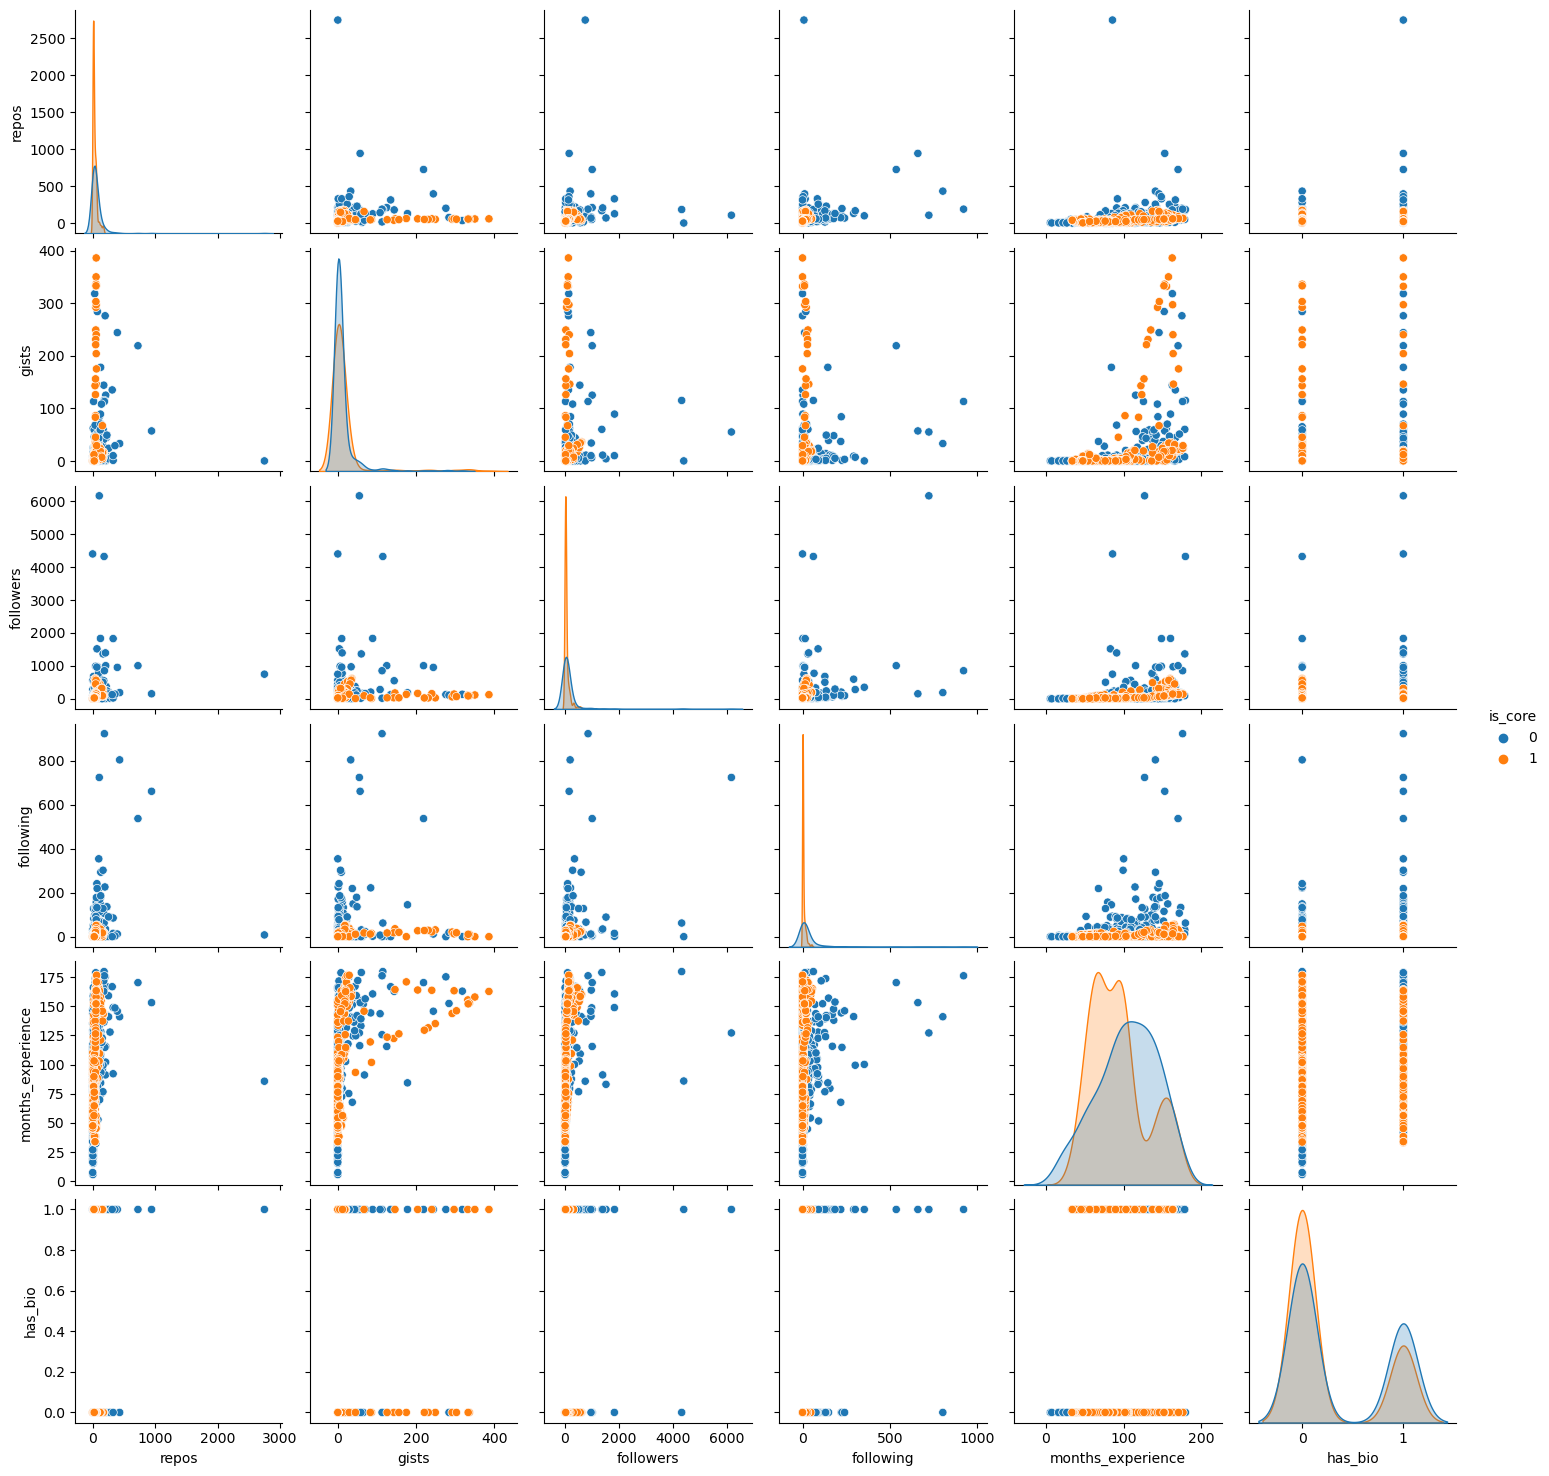

In [9]:
sns.pairplot(c2_train, hue = 'is_core')

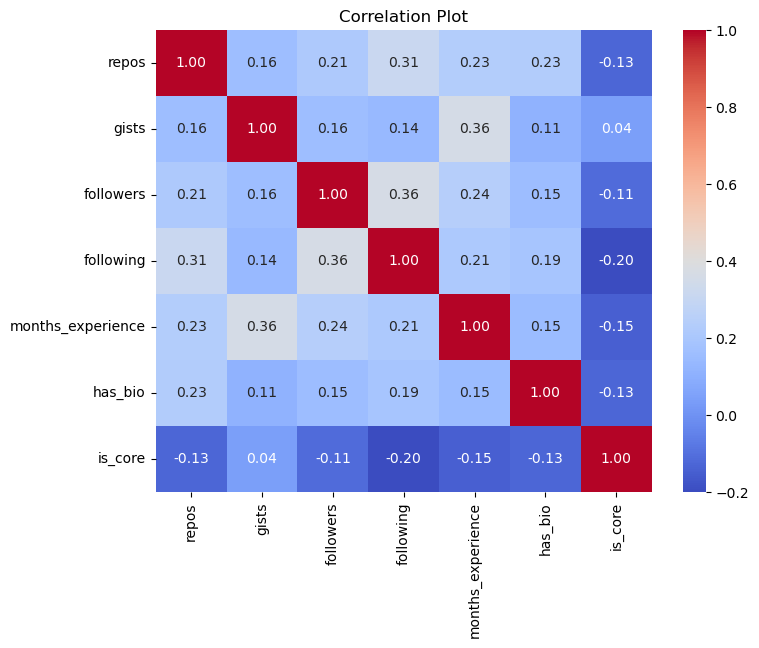

In [10]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c2_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

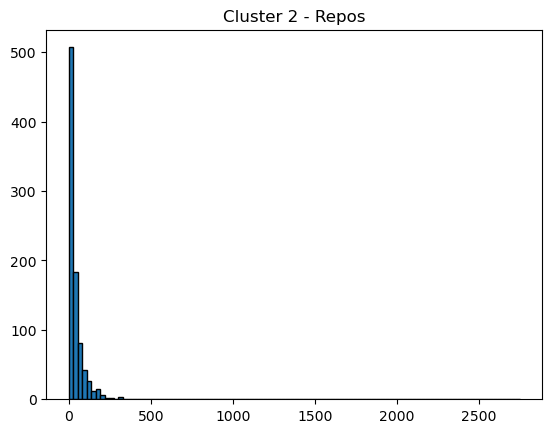

In [11]:
plt.hist(c2_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 2 - Repos')
plt.show()

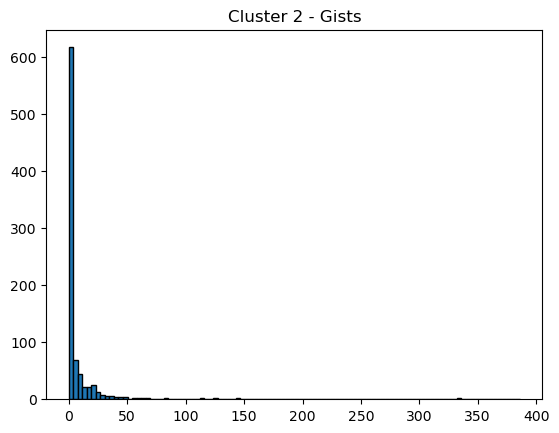

In [12]:
plt.hist(c2_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 2 - Gists')
plt.show()

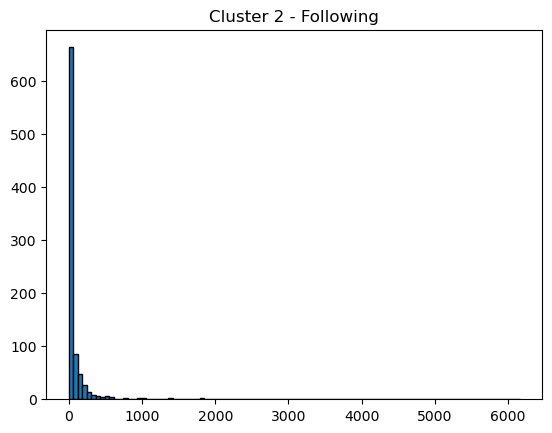

In [13]:
plt.hist(c2_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 2 - Following')
plt.show()

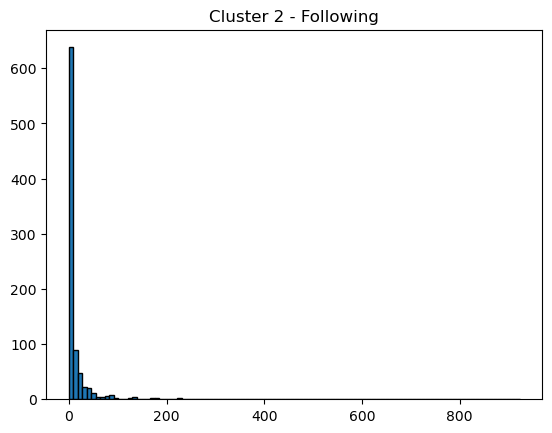

In [14]:
plt.hist(c2_train.following, bins=100, edgecolor='black')
plt.title('Cluster 2 - Following')
plt.show()

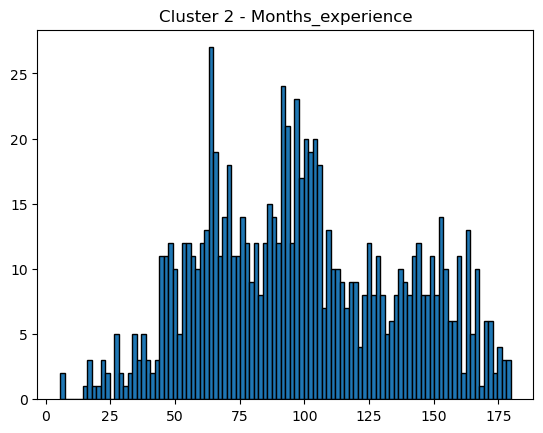

In [15]:
plt.hist(c2_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 2 - Months_experience')
plt.show()

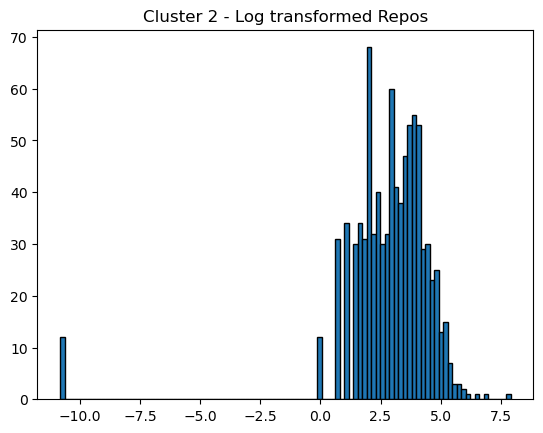

In [16]:
plt.hist(np.log(c2_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Repos')
plt.show()

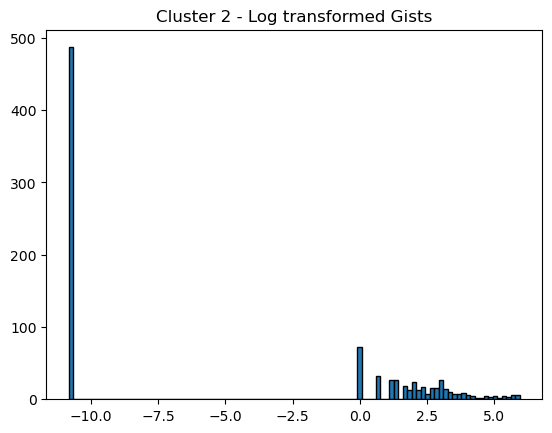

In [17]:
plt.hist(np.log(c2_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Gists')
plt.show()

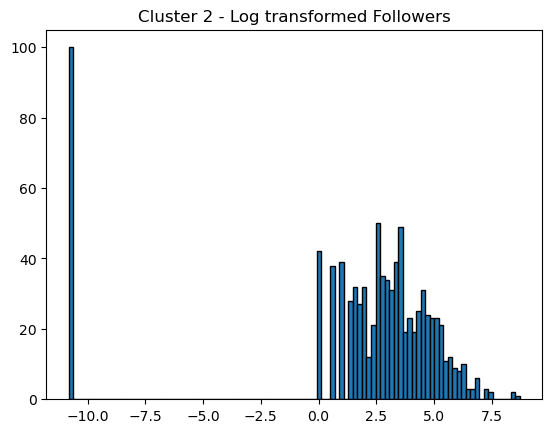

In [18]:
plt.hist(np.log(c2_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Followers')
plt.show()

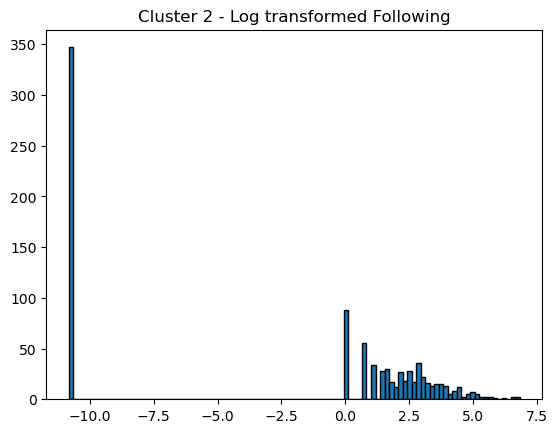

In [19]:
plt.hist(np.log(c2_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Following')
plt.show()

In [20]:
c2_train_log = c2_train.copy()
c2_train_log['repos'] = np.log(c2_train_log.repos+2e-5)
c2_train_log['gists'] = np.log(c2_train_log.gists+2e-5)
c2_train_log['followers'] = np.log(c2_train_log.followers+2e-5)
c2_train_log['following'] = np.log(c2_train_log.following+2e-5)
c2_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core
0,1.098619,-10.819778,0.000020,-10.819778,99.200000,0,0
1,1.609442,-10.819778,-10.819778,-10.819778,80.570000,0,0
2,3.555349,0.000020,3.610918,1.945913,86.980000,0,0
3,1.098619,-10.819778,5.638355,-10.819778,113.630000,0,0
4,4.465908,0.693157,3.178055,3.091043,104.600000,1,0
...,...,...,...,...,...,...,...
882,3.332205,-10.819778,3.526361,0.693157,72.255968,1,1
883,2.995733,-10.819778,2.708052,0.693157,89.675413,1,1
884,3.218877,1.609442,3.295838,0.000020,64.527445,1,1
885,3.044523,2.484908,2.890373,0.000020,56.195912,1,1


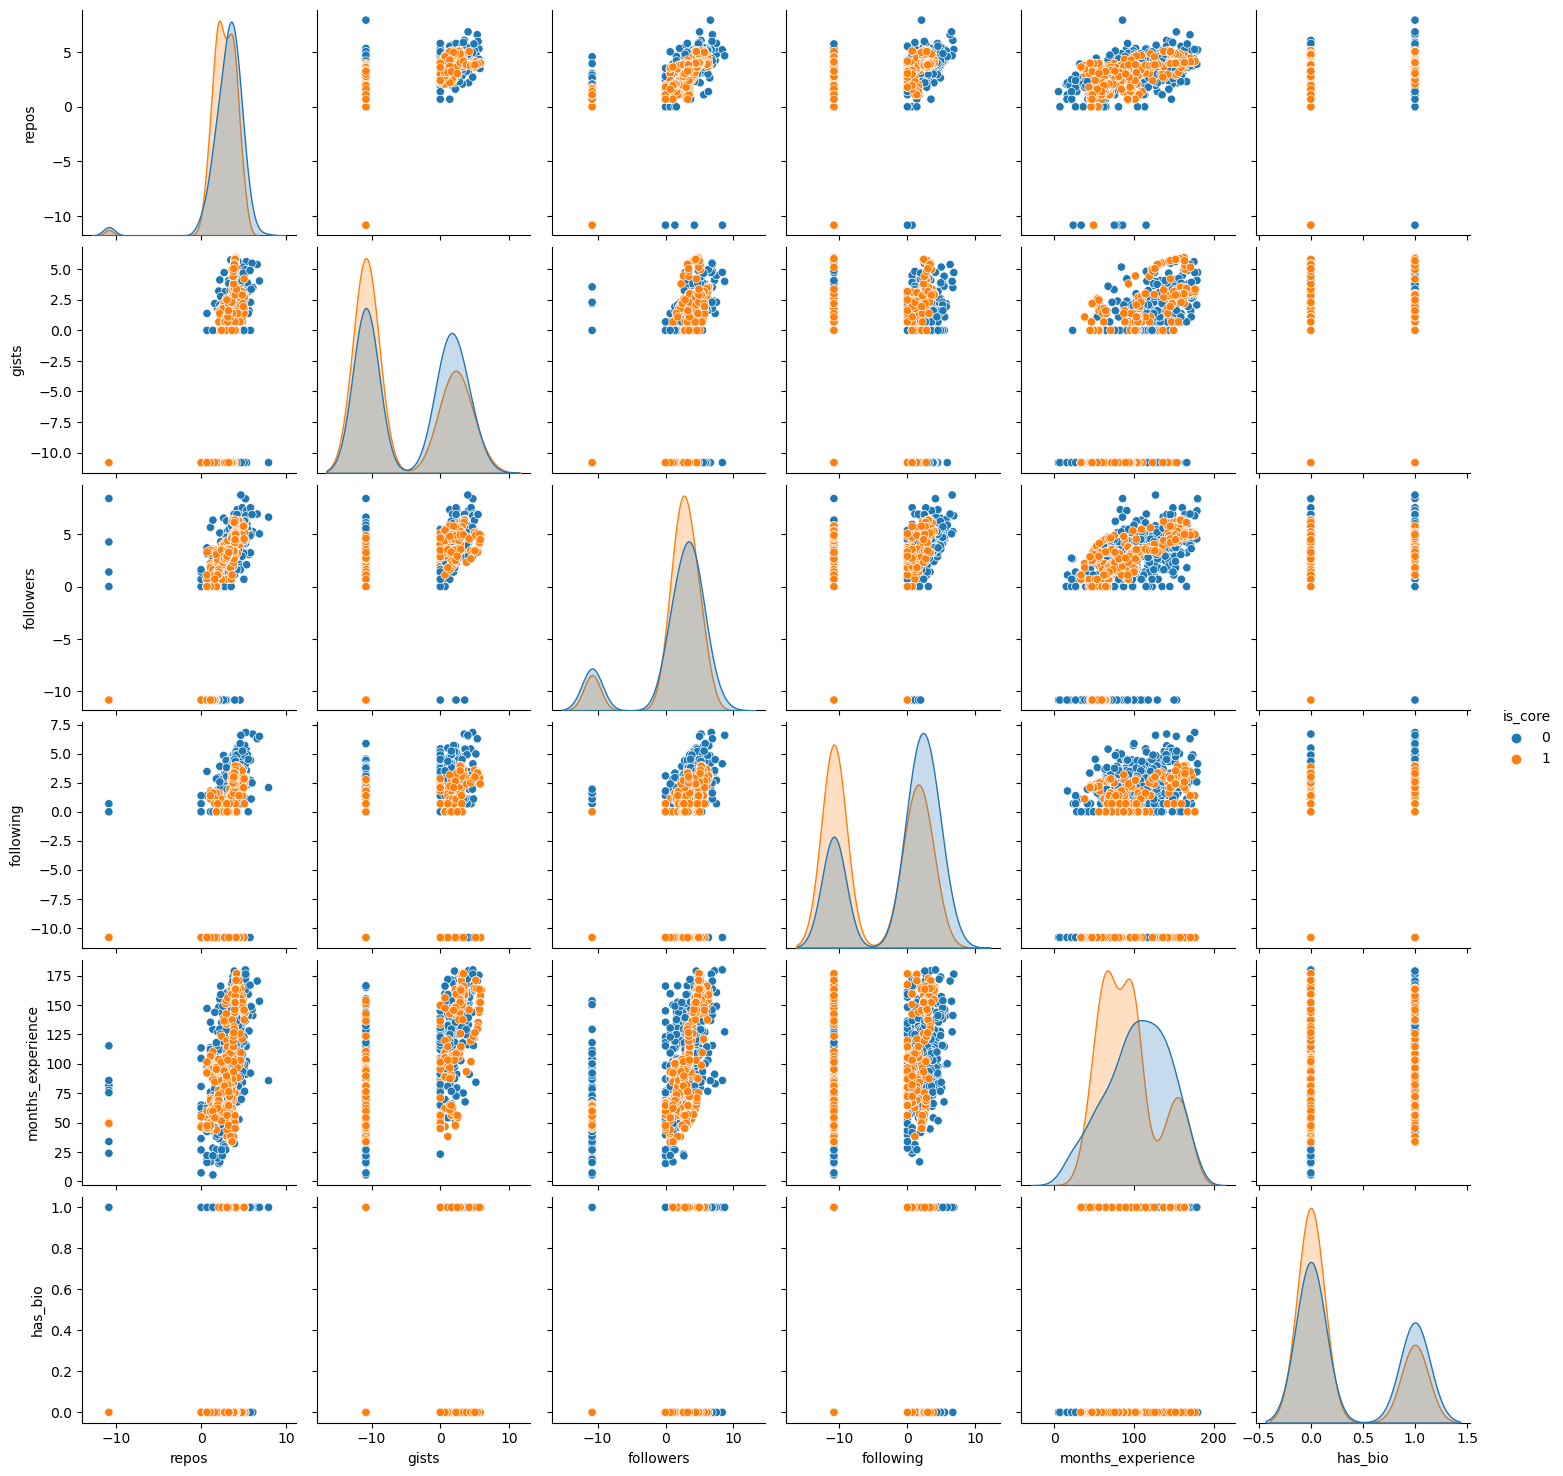

In [21]:
sns.pairplot(c2_train_log, hue = 'is_core')

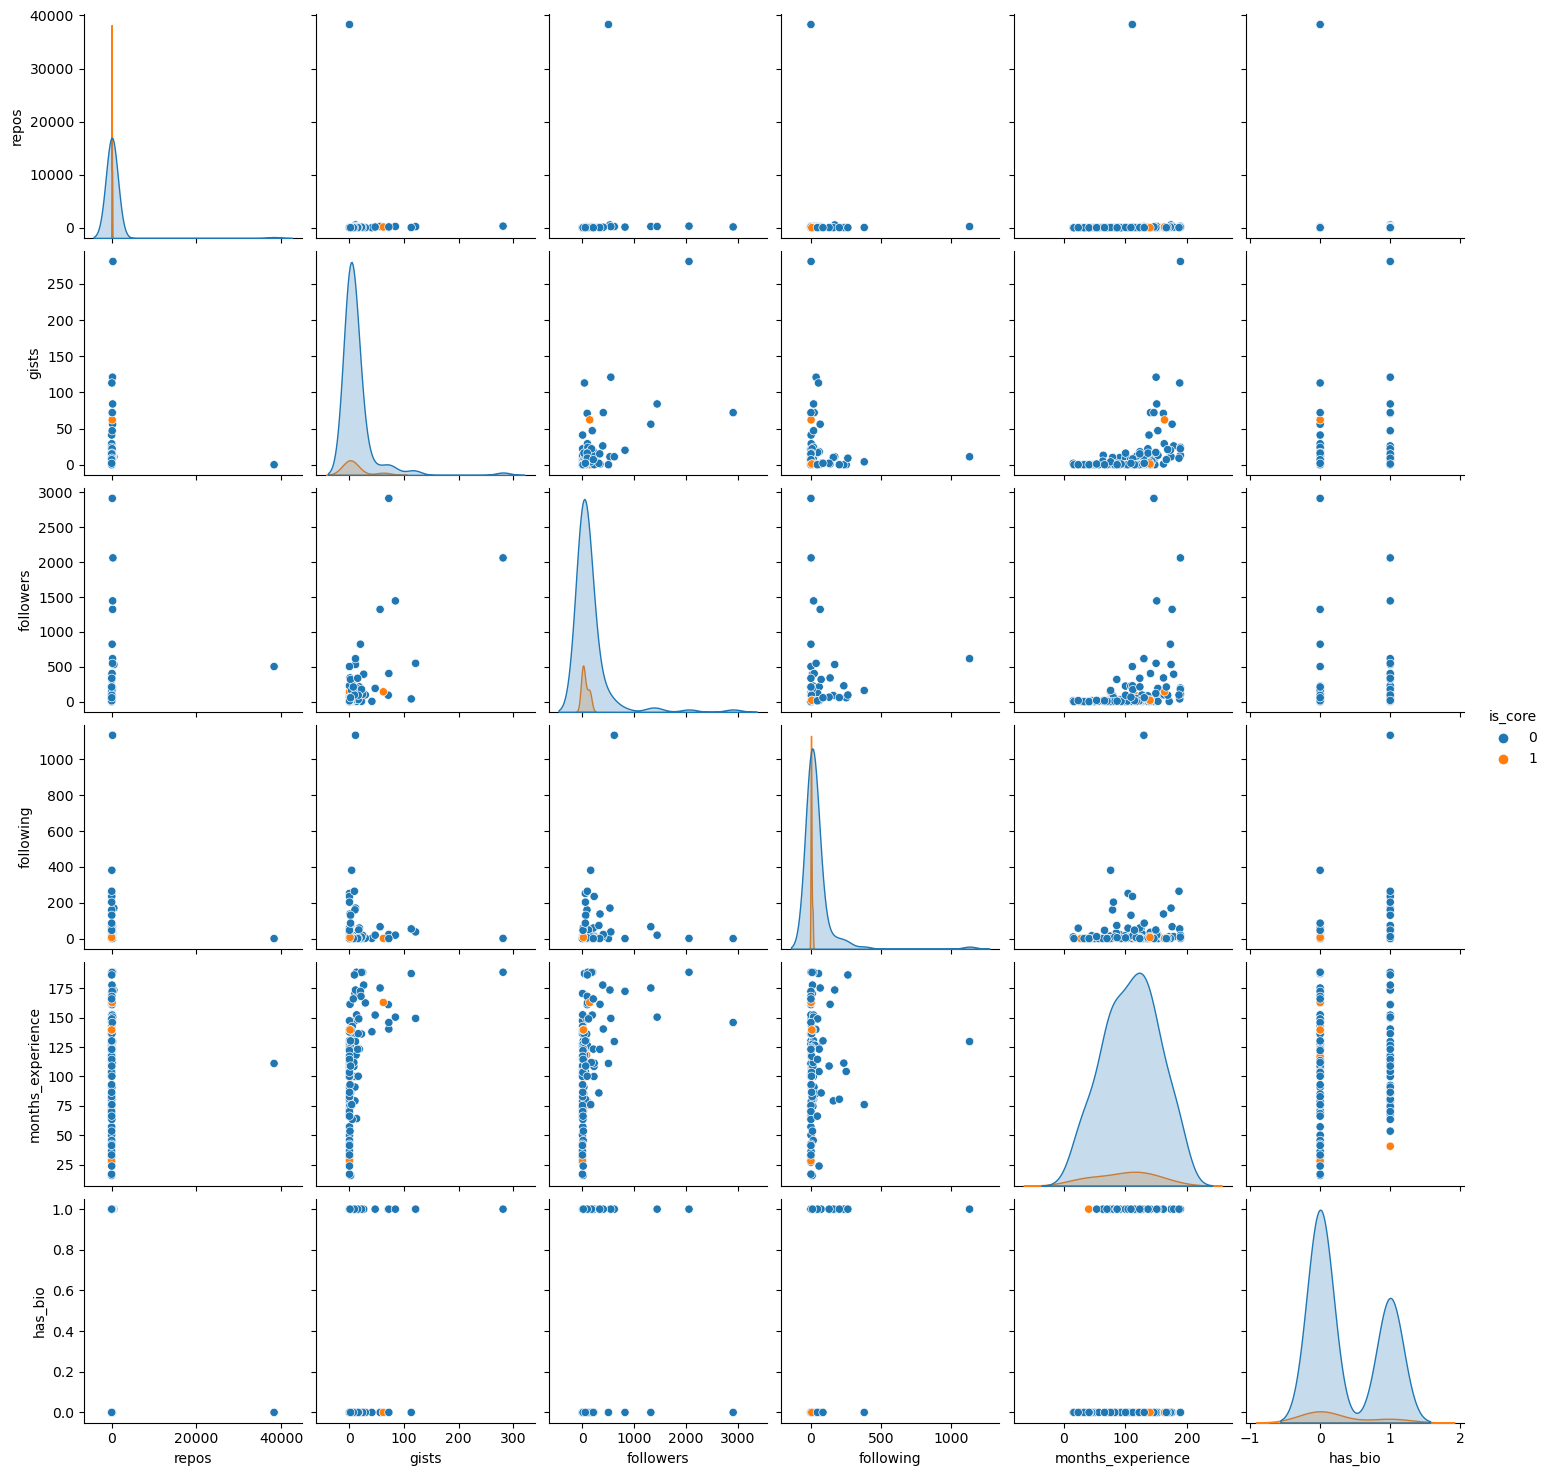

In [22]:
sns.pairplot(test_df, hue = 'is_core')

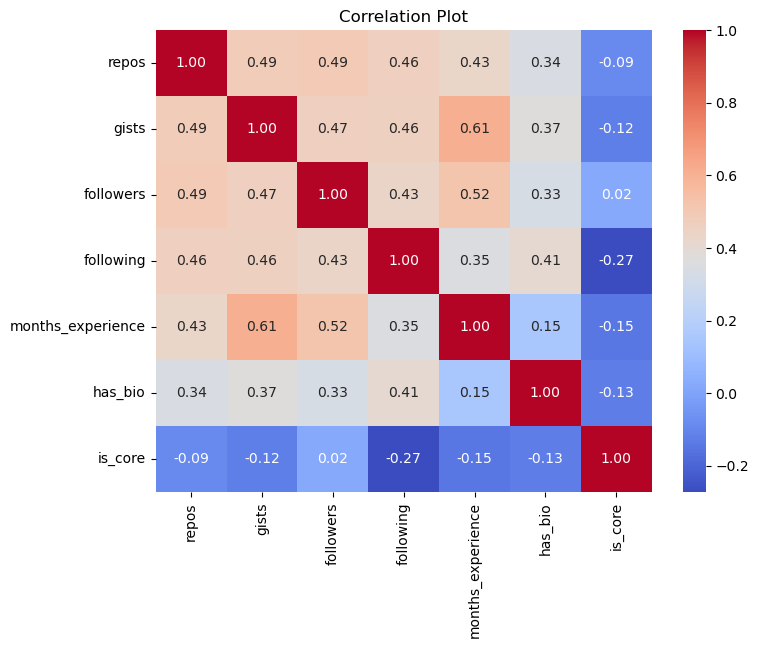

In [23]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c2_train_log.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

In [24]:
X = c2_train_log.drop('is_core', axis=1)
y = c2_train_log['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0452
gists: 0.0348
followers: 0.0454
following: 0.0516
months_experience: 0.0882
has_bio: 0.0000


In [25]:
X = c2_train.drop('is_core', axis=1)
y = c2_train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0486
gists: 0.0518
followers: 0.0542
following: 0.0713
months_experience: 0.0884
has_bio: 0.0000


In [26]:
#scaler = StandardScaler()
#x = scaler.fit_transform(x)
#c2_adasyn_log_scaled = pd.DataFrame(x, columns=['repos', 'gists', 'followers', 'following', 'months_experience'])
#c2_adasyn_log_scaled = pd.concat([c2_adasyn_log_scaled, x2], axis = 1)
#c2_adasyn_log_scaled